In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

from decord import VideoReader, cpu

# you should run this notebook in the root directory of the project for the following imports to work
# %cd ..
%cd /private/home/pfz/00-watermark/hidden
from videoseal.wm.watermarker import Hidden256, DctDwt, HiddenVideo
from videoseal.wm import utils_vid

/private/home/pfz/00-watermark/hidden


/private/home/pfz/anaconda3/envs/stablesign/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load and build models 

In [2]:
"""
This network has been trained in 2 steps
1. train the encoder and decoder without perceptual attenuation, at resolution 256
2. train the encoder with perceptual attenuation and downscaling, at resolution 512 -> downscaled to 256

The corresponding command lines are:
1. torchrun --nproc_per_node=2 main.py --local_rank 0 --batch_size 16 --p_color_jitter 0.0 --p_blur 1.0 --p_rot 1.0 --p_crop 1.0 --p_res 1.0 --p_jpeg 1.0 --scaling_w 0.3 --scale_channels False --attenuation none --loss_margin 1 --loss_w_type bce --scheduler CosineLRScheduler,lr_min=1e-6,t_initial=600,warmup_lr_init=1e-6,warmup_t=10 --optimizer Lamb,lr=2e-3 --epochs 600 --img_size 256 --num_bits 48 --eval_freq 5 --val_dir /datasets01/COCO/060817/test2014/ --train_dir /datasets01/COCO/060817/train2014/ --output_dir /checkpoint/pfz/2023_logs/0828_hidden_multiscale_new/_scaling_w=0.3_optimizer=Lamb,lr=2e-3
2. torchrun --nproc_per_node=2 main.py --local_rank 0 --batch_size 16 --batch_size_eval 32 --p_color_jitter 0.0 --p_blur 1.0 --p_rot 1.0 --p_crop 1.0 --p_res 1.0 --p_jpeg 1.0 --scaling_w 1.0 --scale_channels False --attenuation jnd --downsampling_res 128 --loss_margin 1 --loss_w_type bce --scheduler CosineLRScheduler,lr_min=1e-6,t_initial=100,warmup_lr_init=1e-6,warmup_t=5 --optimizer Lamb,lr=1e-3 --discriminator none --epochs 100 --img_size 512 --num_bits 48 --eval_freq 5 --resume_from /checkpoint/pfz/2023_logs/0828_hidden_multiscale_new/_scaling_w=0.3_optimizer=Lamb,lr=2e-3/checkpoint.pth --val_dir /datasets01/COCO/060817/test2014/ --train_dir /datasets01/COCO/060817/train2014/ --output_dir /checkpoint/pfz/2023_logs/0904_hidden_best_ctd_512_downsample_bis/_downsampling_res=128 
"""
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f"running on device: {device}")

nbits = 48

ckpt_path = "/private/home/pfz/00-watermark/hidden/models/0904_train256_ft512to256.pth"
# dtype should be float32 for this model (fast conv not implem on float16)
# scaling_w: img_wm = img_ori + scaling_w + delta, the higher the more visible the watermark
# resize_to: resize the image to this size before cmoputing the delta
watermarker_hidden = HiddenVideo(ckpt_path, scaling_w=1.0, device=device, dtype="float32", resize_to=256)

running on device: cpu
loading weights from /private/home/pfz/00-watermark/hidden/models/0904_train256_ft512to256.pth
<All keys matched successfully>
<All keys matched successfully>


### Video encode

In [26]:
# import tqdm

# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision.transforms as transforms

# from videoseal.wm import utils_img
# from videoseal.wm import models
# from videoseal.wm.watermarker import Watermarker
# from videoseal.wm import attenuations
# from videoseal.wm import utils_vid


# class EncoderVideo(nn.Module):
#     def __init__(
#         self, 
#         encoder: nn.Module, 
#         attenuation: attenuations.JND, 
#         scale_channels: bool,
#         scaling_i: float,
#         scaling_w: float,
#         chunk_size: int=16,
#         step_size: int=4,
#         resize_to: int=256,
#         device: str='cpu',
#     ):
#         super().__init__()
#         self.encoder = encoder
#         self.attenuation = attenuation
#         self.scale_channels = scale_channels
#         self.scaling_i = scaling_i
#         self.scaling_w = scaling_w
#         self.resize_to = transforms.Resize(resize_to, antialias=True) # short edge to 256
#         self.chunk_size = chunk_size
#         self.step_size = step_size
#         self.device = device

#     def forward(
#         self,
#         frames: torch.Tensor,
#         msg: torch.Tensor,
#     ):
#         """ 
#         Does the forward pass of the encoder only.
#         Rescale the watermark signal by a JND (just noticeable difference heatmap) that says where pixel can be changed without being noticed.
#         The watermark signal is computed on the image downsampled to 256x... pixels, and then upsampled to the original size.
#         The watermark signal is computed every step_size frames and propagated to the next step_size frames.

#         Args:
#             frames (t c h w): the video frames to watermark
#             msg (1 k): the message to encode
#         """

#         # encode by chunk of 8 frames, propagate the wm to 4 next frames
#         chunk_size = self.chunk_size  # n
#         step_size = self.step_size
#         msg = msg.repeat(chunk_size, 1).to(self.device) # 1 k -> n k

#         # initialize watermarked frames
#         frames_w = torch.zeros_like(frames) # f 3 h w

#         for ii in tqdm.tqdm(range(0, len(frames[::step_size]), chunk_size)):
#             nframes_in_ck = min(chunk_size, len(frames[::step_size]) - ii)
#             all_frames_in_ck = frames[ii*step_size : ii*step_size + nframes_in_ck*step_size, ...] # f 3 h w

#             # choose one frame every step_size
#             frames_in_ck = all_frames_in_ck[::step_size] # n 3 h w
#             # downsampling with fixed short edge
#             frames_in_ck = self.resize_to(frames_in_ck).to(self.device) # n 3 wm_h wm_w
#             # deal with last chunk
#             if nframes_in_ck < chunk_size:  
#                 msg = msg[:nframes_in_ck]
            
#             # get deltas for the chunk, and repeat them for each frame in the chunk
#             deltas_in_ck = self.encoder(frames_in_ck, msg) # n 3 wm_h wm_w
#             deltas_in_ck = torch.repeat_interleave(deltas_in_ck, step_size, dim=0) # f 3 wm_h wm_w
#             deltas_in_ck = deltas_in_ck[:len(all_frames_in_ck)] # at the end of video there might be more frames than needed
#             deltas_in_ck = deltas_in_ck.cpu()

#             # scaling channels: more weight to blue channel
#             if self.scale_channels:
#                 aa = 1/4.6 # such that aas has mean 1
#                 aas = torch.tensor([aa*(1/0.299), aa*(1/0.587), aa*(1/0.114)]).to(deltas_w.device) 
#                 deltas_w = deltas_w * aas[None,:,None,None]

#             # upsampling
#             deltas_in_ck = nn.functional.interpolate(deltas_in_ck, size=frames.shape[-2:], mode='bilinear', align_corners=True)

#             # create heatmaps
#             if self.attenuation is not None:
#                 heatmaps = self.attenuation.heatmaps(all_frames_in_ck) # b 1 h w
#                 # remove nan and inf that may appear in because of float16
#                 mask_nan = torch.isnan(heatmaps)
#                 mask_inf = torch.isinf(heatmaps)
#                 heatmaps[mask_nan] = 0.
#                 heatmaps[mask_inf] = 0.083 # max value observed among 100 heatmaps

#             # apply heatmaps and deltas
#             all_frames_in_ck = (all_frames_in_ck + self.scaling_w * deltas_in_ck * heatmaps) # f 3 h w
#             frames_w[ii*step_size : ii*step_size + nframes_in_ck*step_size, ...] = all_frames_in_ck # n 3 h w

#         return frames_w


# class HiddenVideo(Watermarker):

#     def __init__(self, 
#                 encdec_path: str,
#                 scaling_w: float,
#                 resize_to: int,
#                 step_size: int=4,
#                 device: str,
#                 dtype: str="float32",
#                 return_aux: bool=False,
#                 **kwargs):
        
#         self.normalize = utils_img.normalize_img
#         self.unnormalize = utils_img.unnormalize_img

#         # build
#         self.decoder = models.HiddenDecoder(
#             num_blocks=8, 
#             num_bits=48, 
#             channels=64,
#             multi_scale=False
#         )
#         encoder = models.HiddenEncoder(
#             num_blocks=4, 
#             num_bits=48, 
#             channels=64
#         )
#         attenuation = attenuations.JND(preprocess=self.unnormalize).to(device)

#         # loading weights
#         print(f"loading weights from {encdec_path}")
#         state_dict = torch.load(encdec_path, map_location='cpu')['encoder_decoder']
#         encoder_decoder_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
#         encoder_state_dict = {k.replace('encoder.', ''): v for k, v in encoder_decoder_state_dict.items() if 'encoder' in k}
#         decoder_state_dict = {k.replace('decoder.', ''): v for k, v in encoder_decoder_state_dict.items() if 'decoder' in k}
#         print(encoder.load_state_dict(encoder_state_dict))
#         print(self.decoder.load_state_dict(decoder_state_dict))

#         # build encoder with jnd and resize to 256
#         self.encoder_with_jnd = EncoderVideo(
#         # self.encoder_with_jnd = models.EncoderVideo(
#             encoder, 
#             attenuation,
#             scale_channels=False,
#             scaling_w=scaling_w,
#             step_size=step_size,
#             scaling_i=1.0,
#             resize_to=resize_to
#         )

#         self.device = device
#         self.encoder_with_jnd.to(device).eval()
#         self.decoder.to(device).eval()

#         # self.dtype = torch.float32
#         self.dtype = torch.float16 if dtype == "float16" else torch.float32
#         self.encoder_with_jnd = self.encoder_with_jnd.to(self.dtype)
#         self.decoder = self.decoder.to(self.dtype)

#         self.return_aux = return_aux

#     @torch.no_grad()
#     def encode(self, frames: np.ndarray, msg: np.ndarray) -> np.ndarray:
#         time0 = time.time()
#         msg = torch.tensor(msg, device=self.device, dtype=self.dtype).unsqueeze(0) # 1 k
#         msg = 2*msg-1 # k, hidden uses -1 and 1
#         frames = torch.tensor(frames, dtype=self.dtype) # f 3 h w
#         frames = self.normalize(frames)
#         pre_time = time.time() - time0

#         frames_w = self.encoder_with_jnd(frames, msg) # f 3 h w
#         encoding_time = time.time() - time0 - pre_time
        
#         clip_frames = torch.clamp(self.unnormalize(frames_w), 0, 1)
#         clip_frames = torch.round(255 * clip_frames)/255 
#         clip_frames = clip_frames.cpu().numpy()
#         post_time = time.time() - time0 - pre_time - encoding_time

#         if self.return_aux:
#             aux = {
#                 'pre_time': pre_time,
#                 'encoding_time': encoding_time,
#                 'post_time': post_time,
#             }
#             return clip_frames, aux
#         return clip_frames

#     @torch.no_grad()
#     def decode(self, frames: np.ndarray) -> np.ndarray:
#         time0 = time.time()
#         frames = torch.tensor(frames, dtype=self.dtype) # f 3 h w
#         frames = self.normalize(frames)
#         pre_time = time.time() - time0

#         frames = self.encoder_with_jnd.resize_to(frames)
        
#         chunksize = 16  # n
#         fts = []
#         for ii in tqdm.tqdm(range(0, len(frames), chunksize)):
#             nframes_in_ck = min(chunksize, len(frames) - ii)
#             fts_in_ck = self.decoder(frames[ii:ii+nframes_in_ck].to(self.device)).cpu()
#             fts.append(fts_in_ck)  # n k
#         fts = torch.cat(fts, dim=0) # f k
#         decoded_msg = (fts * fts.abs()).mean(dim=0) # b k -> k
#         # decoded_msg = fts.mean(dim=0) # b k -> k
#         decoding_time = time.time() - time0 - pre_time

#         msg = (decoded_msg > 0).squeeze().numpy()
#         post_time = time.time() - time0 - pre_time - decoding_time

#         if self.return_aux:
#             aux = {
#                 'pre_time': pre_time,
#                 'decoding_time': decoding_time,
#                 'post_time': post_time,
#             }
#             return msg, aux
#         return msg

In [4]:
# create model
from videoseal.wm.watermarker import HiddenVideo
watermarker_hidden = HiddenVideo(ckpt_path, scaling_w=1.0, resize_to=256, step_size=4, device=device, dtype="float32")

# load video
video_path = "imgs/01.mp4"
frames = utils_vid.get_frames_from_vid(video_path)

# create message
np.random.seed(0)
msg = np.random.randint(0, 2, nbits)

# embed message in video
print("encoding...")
frames_wm = watermarker_hidden.encode(frames, msg)

# decode message from watermarked video
print("decoding...")
msg_decoded = watermarker_hidden.decode(frames_wm)
bit_acc = np.mean(msg == msg_decoded)
print(f"bit accuracy: {bit_acc}")

# save video
print("saving...")
save_video_path = "outputs/01_wm.mp4"
os.makedirs(os.path.dirname(save_video_path), exist_ok=True)
utils_vid.save_vid(frames_wm, save_video_path, quality=8.0)


loading weights from /private/home/pfz/00-watermark/hidden/models/0904_train256_ft512to256.pth
<All keys matched successfully>
<All keys matched successfully>


encoding...


100%|██████████| 5/5 [00:25<00:00,  5.17s/it]


decoding...


100%|██████████| 19/19 [00:33<00:00,  1.78s/it]


bit accuracy: 1.0
saving...


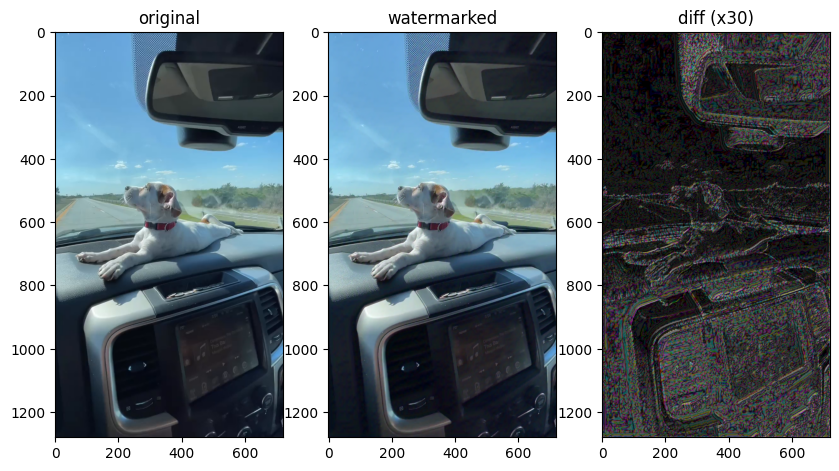

average over 100 frames
psnr: 42.77 dB
ssim: 0.982


In [25]:
# get some image metrics
psnrs = []
ssims = []
plot = True
for frame, frame_wm in zip(utils_vid.to_pil_format(frames)[:100], utils_vid.to_pil_format(frames_wm)[:100]):
    psnr = peak_signal_noise_ratio(frame, frame_wm)
    ssim = structural_similarity(frame, frame_wm, multichannel=True, channel_axis=2)
    psnrs.append(psnr)
    ssims.append(ssim)
    diff = np.abs(frame.astype(int) - frame_wm.astype(int)) * 30
    if plot:
        plot = False
        fig, axs = plt.subplots(1, 3, figsize=(10, 10))
        axs[0].imshow(frame)
        axs[0].set_title("original")
        axs[1].imshow(frame_wm)
        axs[1].set_title("watermarked")
        axs[2].imshow(diff)
        axs[2].set_title("diff (x30)")
        plt.show()
psnr = np.mean(psnrs)
ssim = np.mean(ssims)
print("average over 100 frames")
print(f"psnr: {psnr:.2f} dB")
print(f"ssim: {ssim:.3f}")